In [1]:
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
import skimage
import os
import cv2
import tqdm

In [2]:
TRAIN_PATH = "chest_xray/train/"
VALIDATION_PATH = "chest_xray/val/"
TEST_PATH = "chest_xray/test/"
DISPLAY_P_SAMPLES = "chest_xray/train/PNEUMONIA/"
DISPLAY_N_SAMPLES = "chest_xray/train/NORMAL/"

In [3]:
p_samples = os.listdir(DISPLAY_P_SAMPLES)[:9]
p_samples

['.DS_Store',
 'person1000_bacteria_2931.jpeg',
 'person1000_virus_1681.jpeg',
 'person1001_bacteria_2932.jpeg',
 'person1002_bacteria_2933.jpeg',
 'person1003_bacteria_2934.jpeg',
 'person1003_virus_1685.jpeg',
 'person1004_bacteria_2935.jpeg',
 'person1004_virus_1686.jpeg']

In [4]:
n_samples = os.listdir(DISPLAY_N_SAMPLES)[:9]
n_samples

['.DS_Store',
 'IM-0115-0001.jpeg',
 'IM-0117-0001.jpeg',
 'IM-0119-0001.jpeg',
 'IM-0122-0001.jpeg',
 'IM-0125-0001.jpeg',
 'IM-0127-0001.jpeg',
 'IM-0128-0001.jpeg',
 'IM-0129-0001.jpeg']

In [5]:
def plot_normal_chestxray():
    global n_samples
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('NORMAL_CHEST_XRAY', fontsize=16)

    n_samples = list(filter(lambda x: x != '.DS_Store', n_samples))
    for im, num in zip(n_samples, list(range(len(n_samples)))):
        ax = fig.add_subplot(2,4,num+1)
        img = cv2.imread(os.path.join(DISPLAY_N_SAMPLES, im))
        ax.imshow(img)
        ax.set_title(num+1)
    
    plt.tight_layout()
    plt.show()

In [6]:
def plot_pneumonia_chestxray():
    global p_samples
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('PNEUMONIA_CHEST_XRAY', fontsize=16)

    p_samples = list(filter(lambda x: x != '.DS_Store', p_samples))
    for im, num in zip(p_samples, list(range(len(p_samples)))):
        ax = fig.add_subplot(2,4,num+1)
        img = cv2.imread(os.path.join(DISPLAY_P_SAMPLES, im))
        ax.imshow(img)
        ax.set_title(num+1)
    
    plt.tight_layout()
    plt.show()

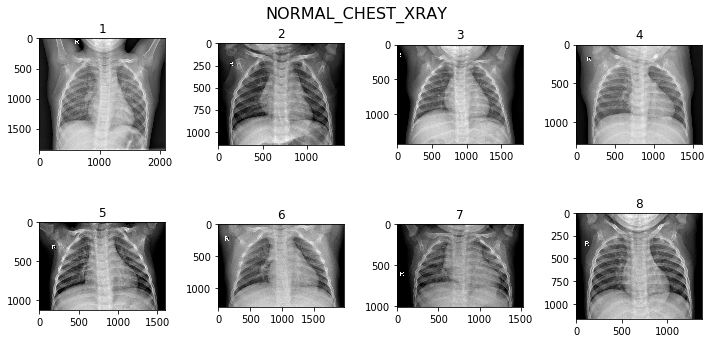

In [7]:
plot_normal_chestxray()

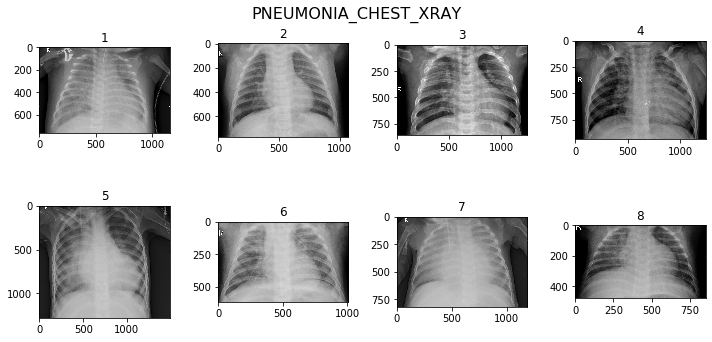

In [8]:
plot_pneumonia_chestxray()

In [9]:
#Preparing data for ImageDataGenerator

def extract_data(path_directory):
    X = []
    y = []
    for nextdirectory in os.listdir(path_directory):
        if not nextdirectory.startswith('.'):
            if nextdirectory in ['NORMAL']:
                label = 0
            elif nextdirectory in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = path_directory + nextdirectory
                
            for file in tqdm.tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [10]:
X_train, y_train = extract_data(TRAIN_PATH)

100%|██████████████████████████████████████████████████████████████████████████████| 3876/3876 [14:59<00:00,  4.31it/s]


In [11]:
X_test , y_test = extract_data(TEST_PATH)

100%|████████████████████████████████████████████████████████████████████████████████| 390/390 [01:09<00:00,  5.65it/s]


In [14]:
X_train.shape, y_train.shape

((5216, 150, 150, 3), (5216,))

In [15]:
X_test.shape, y_test.shape

((624, 150, 150, 3), (624,))

In [16]:
import tensorflow
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

W0916 13:36:55.725489  2116 callbacks.py:1791] `epsilon` argument is deprecated and will be removed, use `min_delta` instead.


In [19]:
savepath="pneumonia_inceptionv3_weights.hdf5"
checkpoint = ModelCheckpoint(savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [20]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout , GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD , RMSprop , Adadelta , Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [21]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [22]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

W0916 13:37:11.544965  2116 deprecation.py:506] From C:\Users\admin\Anaconda3\envs\ml\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [23]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [24]:
base_model.load_weights("inception_v3_weights.h5")

In [25]:
#Combining the base model Inceptionv3 and our output layers binary class prediction
model = Model(inputs=base_model.input, outputs=predictions)

In [26]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

In [27]:
# Inception v3 architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 150, 150) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 74, 74)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 74, 74)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 74, 74)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
mixed0 (Concatenate)            (None, 256, 16, 16)  0           activation_5[0][0]               
                                                                 activation_7[0][0]               
                                                                 activation_10[0][0]              
                                                                 activation_11[0][0]              
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 64, 16, 16)   16384       mixed0[0][0]                     
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 64, 16, 16)   192         conv2d_15[0][0]                  
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 64, 16, 16)   192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 64, 16, 16)   192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 96, 16, 16)   288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, 64, 16, 16)   192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 64, 16, 16)   0           batch_normalization_19[0][0]     
__________

batch_normalization_37 (BatchNo (None, 128, 7, 7)    384         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_32 (Activation)      (None, 128, 7, 7)    0           batch_normalization_32[0][0]     
__________________________________________________________________________________________________
activation_37 (Activation)      (None, 128, 7, 7)    0           batch_normalization_37[0][0]     
__________________________________________________________________________________________________
average_pooling2d_3 (AveragePoo (None, 768, 7, 7)    0           mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 192, 7, 7)    147456      mixed3[0][0]                     
__________________________________________________________________________________________________
conv2d_33 

__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, 192, 7, 7)    576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, 192, 7, 7)    576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, 192, 7, 7)    576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 192, 7, 7)    576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 192, 7, 7)    0           batch_normalization_40[0][0]     
__________

activation_59 (Activation)      (None, 192, 7, 7)    0           batch_normalization_59[0][0]     
__________________________________________________________________________________________________
mixed6 (Concatenate)            (None, 768, 7, 7)    0           activation_50[0][0]              
                                                                 activation_53[0][0]              
                                                                 activation_58[0][0]              
                                                                 activation_59[0][0]              
__________________________________________________________________________________________________
conv2d_64 (Conv2D)              (None, 192, 7, 7)    147456      mixed6[0][0]                     
__________________________________________________________________________________________________
batch_normalization_64 (BatchNo (None, 192, 7, 7)    576         conv2d_64[0][0]                  
__________

batch_normalization_73 (BatchNo (None, 192, 7, 7)    576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 192, 7, 7)    0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 192, 7, 7)    147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, 192, 7, 7)    258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 192, 7, 7)    576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

activation_83 (Activation)      (None, 384, 3, 3)    0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 192, 3, 3)    576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, 320, 3, 3)    0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
mixed9_0 (Concatenate)          (None, 768, 3, 3)    0           activation_78[0][0]              
                                                                 activation_79[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 768, 3, 3)    0           activation_82[0][0]              
          

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048, 3, 3)   0           mixed10[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 2048)         0           dropout[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          262272      global_average_pooling2d[0][0]   
__________________________________________________________________________________________________
batch_norm

In [30]:
batch_size = 256
epochs = 6

In [31]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5184/5216 [============================>.] - ETA: 54s - loss: 0.2941 - acc: 0.81 - ETA: 51s - loss: 0.1520 - acc: 0.90 - ETA: 49s - loss: 0.1032 - acc: 0.93 - ETA: 48s - loss: 0.0802 - acc: 0.95 - ETA: 47s - loss: 0.0679 - acc: 0.96 - ETA: 47s - loss: 0.0657 - acc: 0.96 - ETA: 47s - loss: 0.0642 - acc: 0.96 - ETA: 46s - loss: 0.0573 - acc: 0.96 - ETA: 46s - loss: 0.0515 - acc: 0.97 - ETA: 46s - loss: 0.0624 - acc: 0.96 - ETA: 45s - loss: 0.0739 - acc: 0.96 - ETA: 45s - loss: 0.0696 - acc: 0.97 - ETA: 44s - loss: 0.0773 - acc: 0.97 - ETA: 44s - loss: 0.0790 - acc: 0.97 - ETA: 44s - loss: 0.0742 - acc: 0.97 - ETA: 44s - loss: 0.0717 - acc: 0.97 - ETA: 43s - loss: 0.0687 - acc: 0.97 - ETA: 43s - loss: 0.0670 - acc: 0.97 - ETA: 43s - loss: 0.0680 - acc: 0.97 - ETA: 42s - loss: 0.0669 - acc: 0.97 - ETA: 42s - loss: 0.0648 - acc: 0.97 - ETA: 42s - loss: 0.0692 - acc: 0.97 - ETA: 41s - loss: 0.0674 - acc: 0.97 - ETA: 41s - loss: 0.0663 

5184/5216 [============================>.] - ETA: 54s - loss: 0.0704 - acc: 0.96 - ETA: 51s - loss: 0.0409 - acc: 0.98 - ETA: 50s - loss: 0.0294 - acc: 0.98 - ETA: 49s - loss: 0.0282 - acc: 0.99 - ETA: 49s - loss: 0.0310 - acc: 0.99 - ETA: 49s - loss: 0.0281 - acc: 0.99 - ETA: 48s - loss: 0.0356 - acc: 0.99 - ETA: 48s - loss: 0.0379 - acc: 0.99 - ETA: 48s - loss: 0.0342 - acc: 0.99 - ETA: 47s - loss: 0.0355 - acc: 0.99 - ETA: 47s - loss: 0.0359 - acc: 0.99 - ETA: 46s - loss: 0.0349 - acc: 0.99 - ETA: 46s - loss: 0.0375 - acc: 0.99 - ETA: 46s - loss: 0.0392 - acc: 0.98 - ETA: 45s - loss: 0.0370 - acc: 0.98 - ETA: 45s - loss: 0.0359 - acc: 0.99 - ETA: 44s - loss: 0.0342 - acc: 0.99 - ETA: 44s - loss: 0.0331 - acc: 0.99 - ETA: 44s - loss: 0.0321 - acc: 0.99 - ETA: 44s - loss: 0.0314 - acc: 0.99 - ETA: 43s - loss: 0.0306 - acc: 0.99 - ETA: 43s - loss: 0.0309 - acc: 0.99 - ETA: 43s - loss: 0.0326 - acc: 0.99 - ETA: 42s - loss: 0.0318 - acc: 0.99 - ETA: 42s - loss: 0.0331 - acc: 0.99 - ETA: 

5184/5216 [============================>.] - ETA: 53s - loss: 0.0412 - acc: 0.96 - ETA: 50s - loss: 0.0527 - acc: 0.95 - ETA: 50s - loss: 0.0479 - acc: 0.95 - ETA: 49s - loss: 0.0381 - acc: 0.96 - ETA: 50s - loss: 0.0326 - acc: 0.97 - ETA: 49s - loss: 0.0279 - acc: 0.97 - ETA: 49s - loss: 0.0267 - acc: 0.98 - ETA: 48s - loss: 0.0374 - acc: 0.98 - ETA: 48s - loss: 0.0394 - acc: 0.97 - ETA: 47s - loss: 0.0380 - acc: 0.98 - ETA: 47s - loss: 0.0392 - acc: 0.98 - ETA: 46s - loss: 0.0367 - acc: 0.98 - ETA: 46s - loss: 0.0346 - acc: 0.98 - ETA: 46s - loss: 0.0371 - acc: 0.98 - ETA: 45s - loss: 0.0361 - acc: 0.98 - ETA: 45s - loss: 0.0364 - acc: 0.98 - ETA: 45s - loss: 0.0430 - acc: 0.98 - ETA: 44s - loss: 0.0409 - acc: 0.98 - ETA: 44s - loss: 0.0391 - acc: 0.98 - ETA: 44s - loss: 0.0388 - acc: 0.98 - ETA: 43s - loss: 0.0373 - acc: 0.98 - ETA: 43s - loss: 0.0359 - acc: 0.98 - ETA: 42s - loss: 0.0353 - acc: 0.98 - ETA: 42s - loss: 0.0341 - acc: 0.98 - ETA: 42s - loss: 0.0344 - acc: 0.98 - ETA: 

5184/5216 [============================>.] - ETA: 49s - loss: 0.0221 - acc: 1.00 - ETA: 48s - loss: 0.0145 - acc: 1.00 - ETA: 48s - loss: 0.0226 - acc: 1.00 - ETA: 48s - loss: 0.0204 - acc: 1.00 - ETA: 47s - loss: 0.0222 - acc: 0.99 - ETA: 47s - loss: 0.0327 - acc: 0.98 - ETA: 47s - loss: 0.0346 - acc: 0.98 - ETA: 46s - loss: 0.0342 - acc: 0.98 - ETA: 46s - loss: 0.0312 - acc: 0.98 - ETA: 45s - loss: 0.0362 - acc: 0.99 - ETA: 45s - loss: 0.0343 - acc: 0.99 - ETA: 45s - loss: 0.0338 - acc: 0.99 - ETA: 45s - loss: 0.0337 - acc: 0.99 - ETA: 44s - loss: 0.0329 - acc: 0.99 - ETA: 44s - loss: 0.0364 - acc: 0.98 - ETA: 44s - loss: 0.0344 - acc: 0.99 - ETA: 44s - loss: 0.0336 - acc: 0.99 - ETA: 43s - loss: 0.0335 - acc: 0.99 - ETA: 43s - loss: 0.0321 - acc: 0.99 - ETA: 43s - loss: 0.0317 - acc: 0.99 - ETA: 42s - loss: 0.0339 - acc: 0.99 - ETA: 42s - loss: 0.0370 - acc: 0.99 - ETA: 42s - loss: 0.0364 - acc: 0.99 - ETA: 41s - loss: 0.0363 - acc: 0.99 - ETA: 41s - loss: 0.0363 - acc: 0.99 - ETA: 

5184/5216 [============================>.] - ETA: 49s - loss: 0.0058 - acc: 1.00 - ETA: 50s - loss: 0.0291 - acc: 1.00 - ETA: 50s - loss: 0.0303 - acc: 0.98 - ETA: 49s - loss: 0.0470 - acc: 0.96 - ETA: 48s - loss: 0.0416 - acc: 0.97 - ETA: 48s - loss: 0.0366 - acc: 0.97 - ETA: 48s - loss: 0.0324 - acc: 0.98 - ETA: 47s - loss: 0.0353 - acc: 0.98 - ETA: 47s - loss: 0.0438 - acc: 0.97 - ETA: 47s - loss: 0.0430 - acc: 0.97 - ETA: 46s - loss: 0.0396 - acc: 0.98 - ETA: 46s - loss: 0.0416 - acc: 0.97 - ETA: 46s - loss: 0.0445 - acc: 0.97 - ETA: 45s - loss: 0.0421 - acc: 0.97 - ETA: 45s - loss: 0.0455 - acc: 0.97 - ETA: 44s - loss: 0.0443 - acc: 0.97 - ETA: 44s - loss: 0.0433 - acc: 0.97 - ETA: 44s - loss: 0.0458 - acc: 0.97 - ETA: 43s - loss: 0.0448 - acc: 0.97 - ETA: 43s - loss: 0.0428 - acc: 0.97 - ETA: 43s - loss: 0.0414 - acc: 0.98 - ETA: 42s - loss: 0.0415 - acc: 0.98 - ETA: 42s - loss: 0.0424 - acc: 0.97 - ETA: 42s - loss: 0.0474 - acc: 0.97 - ETA: 42s - loss: 0.0524 - acc: 0.97 - ETA: 

5184/5216 [============================>.] - ETA: 54s - loss: 0.0199 - acc: 1.00 - ETA: 51s - loss: 0.0182 - acc: 1.00 - ETA: 50s - loss: 0.0239 - acc: 0.98 - ETA: 49s - loss: 0.0343 - acc: 0.98 - ETA: 48s - loss: 0.0341 - acc: 0.98 - ETA: 48s - loss: 0.0308 - acc: 0.98 - ETA: 47s - loss: 0.0293 - acc: 0.99 - ETA: 47s - loss: 0.0262 - acc: 0.99 - ETA: 46s - loss: 0.0238 - acc: 0.99 - ETA: 46s - loss: 0.0251 - acc: 0.99 - ETA: 46s - loss: 0.0352 - acc: 0.98 - ETA: 45s - loss: 0.0350 - acc: 0.98 - ETA: 45s - loss: 0.0361 - acc: 0.98 - ETA: 45s - loss: 0.0348 - acc: 0.98 - ETA: 44s - loss: 0.0404 - acc: 0.98 - ETA: 44s - loss: 0.0391 - acc: 0.98 - ETA: 44s - loss: 0.0375 - acc: 0.98 - ETA: 43s - loss: 0.0479 - acc: 0.98 - ETA: 43s - loss: 0.0472 - acc: 0.98 - ETA: 43s - loss: 0.0506 - acc: 0.97 - ETA: 43s - loss: 0.0500 - acc: 0.97 - ETA: 42s - loss: 0.0486 - acc: 0.98 - ETA: 42s - loss: 0.0469 - acc: 0.98 - ETA: 42s - loss: 0.0476 - acc: 0.98 - ETA: 42s - loss: 0.0472 - acc: 0.98 - ETA: 

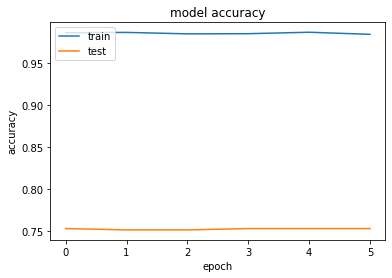

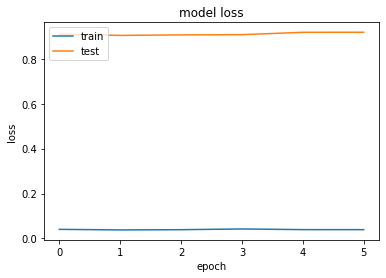

In [32]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

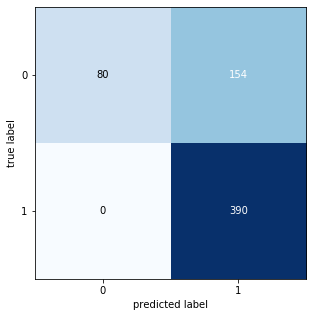

In [45]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

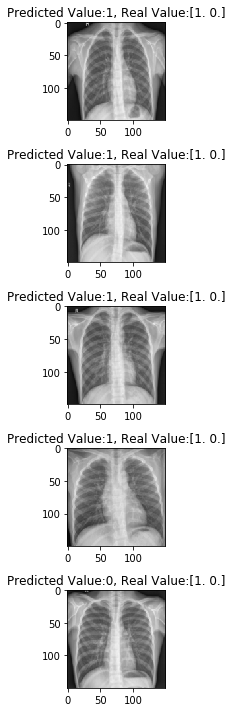

In [50]:
PREDICTION_PATH = 'chest_xray/test/'
fig = plt.figure(figsize=(10,10))
for im, lab, num in zip(X_test[:5], y_test[:5], range(len(X_test[:5]))):
    ax = fig.add_subplot(5,1,num+1)
    ax.imshow(im.reshape(150,150,3))
    ax.set_title(f'Predicted Value:{pred[num]}, Real Value:{lab}')

plt.tight_layout()
plt.show()